## Predicting Players Subscription Status using KNN Classification Modelling 

## Introduction


A research group in Computer Science at UBC has collected data from a Minecraft server, with the goal of predicting usage of a video game research server. This study investigates the factors associated with a player's decision to subscribe to a game-related newsletter. Such a subscription may serve as a proxy for deeper engagement with the server or interest in the research project.


**Re
This study explores the question: *What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter?*  
More specifically, we ask: *Can age and hours played predict whether a player subscribes to the newsletter?*

**Dataset Description**

To answer this question, we analyze a dataset collected from the Minecraft research server. Each row in the dataset represents an individual player, with the following variables:

- `experience`: The level or rank of the player (categorical)
- `played_hours`: The number of hours the player has spent on the server (numerical)
- `gender`: The gender identity of the player (categorical)
- `age`: The age of the player in years (numerical, ordered)
- `subscribe`: Whether the player subscribed to the game-related newsletter 
The response variable is `subscribe`, and the explanatory variables are `age`, `gender`, `experience`, and `played_hours`.

This report will explore relationships between these variables and apply predictive modeling techniques to determine which characteristics are most useful in predicting newsletter subscription.


## Methods
To begin, the appropriate packages - including tidyverse, repr, and tidymodels - are loaded into the notebook. Then, the dataframe is loaded from a public GitHub repository. The data is wrangled using the select, filter, mutate, and drop_na functions. This data is now tailored to answer the research question. The dataframe is plotted on a scatterplot, comparing age to total hours played. Points are coloured according to subscription status, true meaning subscribed and false meaning not subscribed. The dataframe is split into training and testing data, in a 70:30 split. To initially test the prediction accuracy, a knn classification model is run using k = 3. Then, k is tuned using cross validation to determine accuracies and to find the k value with the highest prediction accuracy. Finally, the prediction accuracies were plotted as a line graph to visualize the accuracies of the best ks. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("cleanup.R")
set.seed(1234)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
player_data <- read_csv("https://raw.githubusercontent.com/Cna-51/minecraft_indiv/refs/heads/main/players%20(1).csv") |>
    select(-hashedEmail, -name, -experience) |>
    filter(played_hours > 0) |>
    mutate(subscribe = as.factor(subscribe)) |>
    drop_na()
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
TRUE,30.3,Male,9
TRUE,3.8,Male,17
TRUE,0.7,Female,21
⋮,⋮,⋮,⋮
TRUE,0.1,Female,44
FALSE,0.3,Male,22
FALSE,2.3,Male,17


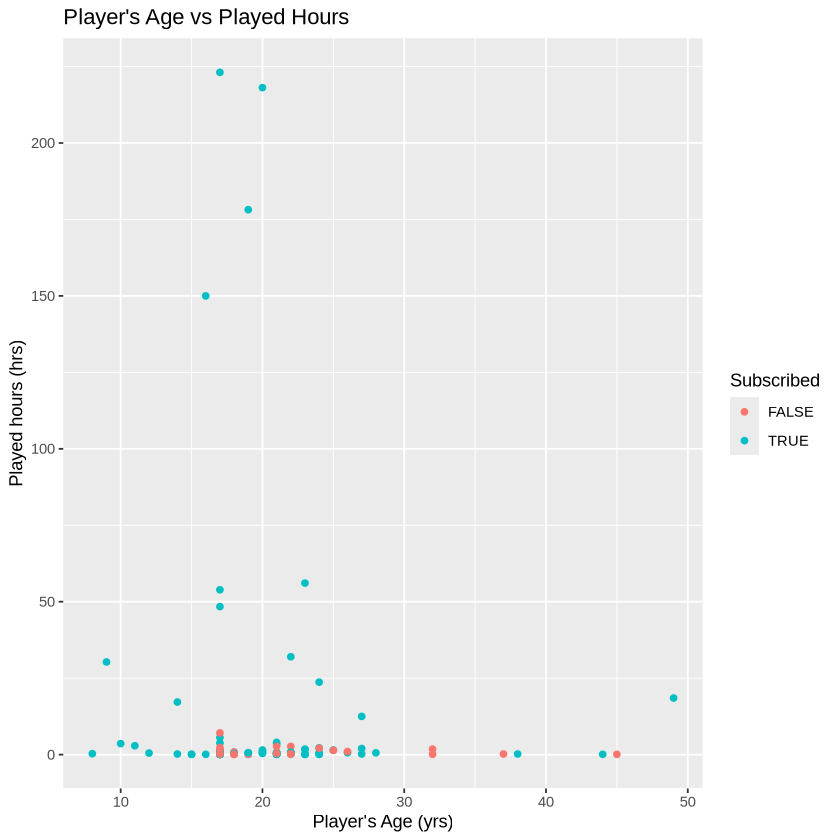

In [3]:
player_plot <- player_data |>
    ggplot(aes(x = Age, y = played_hours, colour = subscribe)) +
    geom_point() +
    labs(x = "Player's Age (yrs)", y = "Played hours (hrs)", colour = "Subscribed", title = "Player's Age vs Played Hours")
player_plot

**Figure 1.** Player's played hours versus their age. Subscription status denoted by the colour of each point. Player ages range from 5 to 49 years old while the played hours range from 0.1 to 223.1 hours of play time.   

In [4]:
player_split <- initial_split(player_data, prop= 0.7-0.3, strata= subscribe) 
player_training <- training(player_split)
player_testing <- testing(player_split)
player_training
player_testing

subscribe,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
FALSE,0.9,Male,18
FALSE,0.1,Male,22
FALSE,0.2,Female,37
⋮,⋮,⋮,⋮
TRUE,0.3,Male,17
TRUE,0.4,Two-Spirited,17
TRUE,0.8,Female,22


subscribe,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
TRUE,30.3,Male,9
TRUE,1.5,Female,25
TRUE,0.2,Male,22
⋮,⋮,⋮,⋮
TRUE,32.0,Male,22
TRUE,0.1,Female,44
FALSE,0.3,Male,22


In [5]:
# First, we'll perform a knn classification with k = 3. 
player_recipe <- recipe(subscribe ~ played_hours + Age, data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")
player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_training)
player_predictions <- predict(player_fit, player_testing) |>
    bind_cols(player_testing)
prediction_accuracy <- player_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)             
prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7878788
kap,binary,0.2968037


This knn classification with k = 3 has an accuracy of around 62%. 

In [6]:
# Then a cross validation is performed to test how this model works when split into multiple sections. 
# This will be done while tuning k to determine the most accurate k value. 
vfolds <- vfold_cv(player_training, v = 5, strata = subscribe) 
player_resample <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit_resamples(resamples = vfolds) 
resample_metrics <- collect_metrics(player_resample)
player_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
tuned_results <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_tune) |>
      tune_grid(resamples = vfolds, grid = k_vals) |>
      collect_metrics()
accuracies <- tuned_results |> 
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
accuracies 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.7666667,5,0.006804138,Preprocessor1_Model07
8,accuracy,binary,0.7666667,5,0.006804138,Preprocessor1_Model08
9,accuracy,binary,0.7666667,5,0.006804138,Preprocessor1_Model09
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,accuracy,binary,0.7250000,5,0.05386311,Preprocessor1_Model04
1,accuracy,binary,0.5138889,5,0.04930066,Preprocessor1_Model01
2,accuracy,binary,0.5138889,5,0.04930066,Preprocessor1_Model02


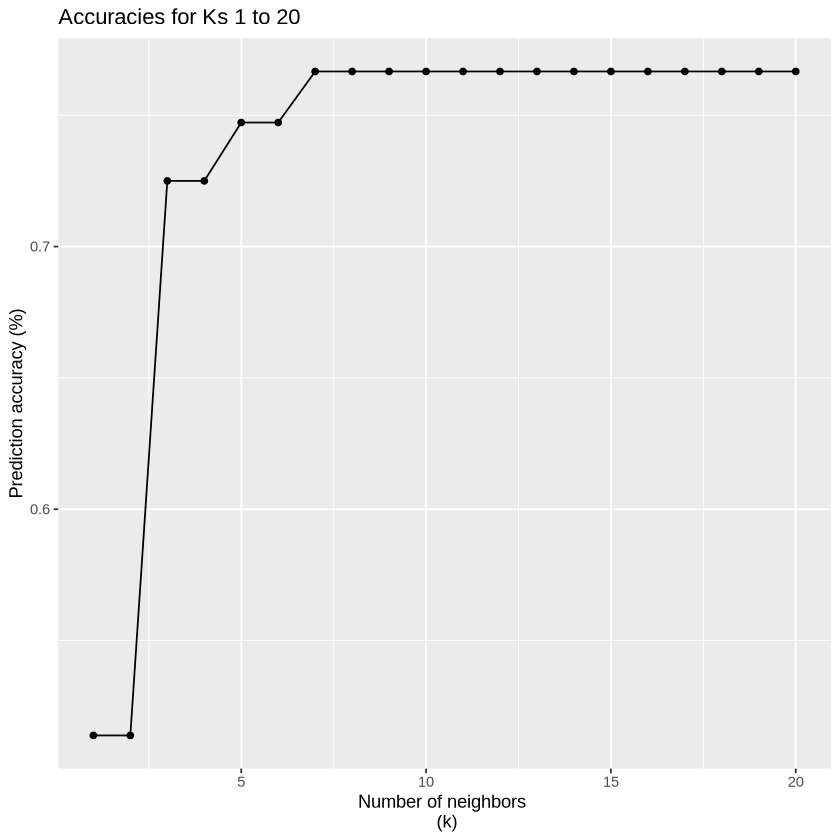

In [7]:
accuracy_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of neighbors \n (k)", y = "Prediction accuracy (%)", title = "Accuracies for Ks 1 to 20")
accuracy_plot

**Figure 2.** Plot of model prediction accuracy versus number of neighbours used in the classification model (k). As k reaches 7, prediction accuracy plateaus at 76.7% and does not increase further for larger values of k.

## Discussion

We found that our model was able to correctly predict whether or not a player was subscribed to the game-related newsletter based on the player's age and hours played approximately 76.7% of the time with a k of at least 7. Interestingly, any k that was greater in 7 did not result in any increase in predition accuracy, suggesting that 76.7% is the maximum accuracy that is able to be obtained using the predictor variables of age and hours played.

This result aligns with what we expected to find. We expected that players who spend more time playing the game are more interested in things related to the game, and would therefore be more likely to subscribe to a game-related newsletter. We also did not expect the model to be able to predict this 100% of the time, due to other confounding variables not included in the model or in the dataset as a whole, such as a person's preference for other forms of coomunications or notifications, and potential email spam or data misuse.

These findings could potentially provide the researchers with insight on reasons for a player subscribing, how they can increase the proportion of players who subscribe to the newsletter, and what the best way to communicate with players is. For example, given our results, the researchers may move to add another variable to the data such as "preferred communication platform" to see if players prefer to receive communications through email, text, or another method. Additionally, they could find a way to incentivise players with lower playig time to subscribe to the newsletter by offering exclusive in-game rewards.

These findings could prompt further exploration of other predictor variables and their effect on newsletter subscribtion, such as investigating if one gender is more likely to subscribe ober the others, or if more experienced players would be more or less likely to subscribe to the newsletter. Specifically, if the newsletter contained content targeted toward beginners with basic tips and tricks, then a more experienced player would likely opt to not subscribe. Conversely, if the newsletter contained more advances techniques for the game and discussed higher-level gameplay, newer players may feel intimidated and reluctant to subscribe. These findings could help the researchers to further refine not only their data collection, but also the content of the newsletter and their overall approach for the study.   